In [1]:
import torch
import torchvision
import torch.nn as nn
import time
import copy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime

print(torch.__version__)
print(torchvision.__version__)

2.3.0+cu121
0.18.0+cu121


In [2]:
def get_all_layers(model):
    all_layers = []
    
    def collect_leaves(module, prefix=''):
        for name, child in module.named_children():
            full_name = f"{prefix}.{name}" if prefix else name
            
            if len(list(child.children())) == 0:
                all_layers.append((full_name, child))
            else:
                collect_leaves(child, prefix=full_name)
    
    collect_leaves(model)
    
    return all_layers

In [3]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torchvision.models import mnasnet1_0, MNASNet1_0_Weights
from torchvision.models import googlenet, GoogLeNet_Weights
from torchvision.models import squeezenet1_0, SqueezeNet1_0_Weights

weights = SqueezeNet1_0_Weights.DEFAULT
model_squeezenet = squeezenet1_0(weights=weights)
model_squeezenet.eval()

weights = GoogLeNet_Weights.DEFAULT
model_googlenet = googlenet(weights=weights)
model_googlenet.eval()

weights = MobileNet_V2_Weights.DEFAULT
model_mobilenet = mobilenet_v2(weights=weights)
model_mobilenet.eval()


weights = MNASNet1_0_Weights.DEFAULT
model_mnasnet = mnasnet1_0(weights=weights)
model_mnasnet.eval()

models = {"squeezenet": model_squeezenet,
         "googlenet": model_googlenet,
         "mobilenet": model_mobilenet,
         "mnasnet": model_mnasnet}

models_original = copy.deepcopy(models)



for name, model in models.items():
    print(f"Model: {name}")
    print(f"Number of modules: {len(list(model.modules()))}")
    print(f"number of leaf layers: {len(get_all_layers(model))} ")
    print("-" * 40)


Model: squeezenet
Number of modules: 68
number of leaf layers: 57 
----------------------------------------
Model: googlenet
Number of modules: 224
number of leaf layers: 130 
----------------------------------------
Model: mobilenet
Number of modules: 213
number of leaf layers: 141 
----------------------------------------
Model: mnasnet
Number of modules: 182
number of leaf layers: 141 
----------------------------------------


In [4]:
class LaLaRAND:
    def __init__(self, model, device_sequence):
        self.model = model
        self.device_sequence = device_sequence
        self.current_device_index = 0
        self.all_layers = self._get_all_layers()
        self.execution_times = {}

        self._register_hooks()

        if len(self.device_sequence) != len(self.all_layers):
            raise ValueError("레이어 수와 device 결정 순서 개수가 일치하지 않음")
        
    def _get_all_layers(self):
        all_layers = []
        
        def recursive_children(module, parent=''):
            for name, child in module.named_children():
                if parent == False:
                    full_name = name
                else:
                    full_name = f"{parent}.{name}" 
                
                if len(list(child.children())) == 0:
                    all_layers.append((full_name, child))
                else:
                    recursive_children(child, parent=full_name)
        recursive_children(self.model)

        return all_layers
    
    def _register_hooks(self):
        for i, (layer_name, layer) in enumerate(self.all_layers):
            device_type = self.device_sequence[i]

            # Pre-hook: 레이어와 입력을 같은 device로 이동
            def make_pre_hook(idx, name, dev_type):
                def pre_hook(module, input):
                    if torch.cuda.is_available():
                        torch.cuda.synchronize() 

                    input_memory_transfer_start_time = time.time()

                    # Target device 결정
                    if dev_type == 0:
                        target_device = 'cpu'
                    else:
                        target_device = 'cuda'  
                    
                    # 레이어를 target device로 이동
                    module.to(target_device)
                    
                    if isinstance(input, tuple):
                        result = []  # 튜플의 각 데이터들 위치 바꾸고 이 리스트에 저장(마지막에 다시 튜플로 변환)
                        for inp in input:
                            result.append(inp.to(target_device))  
                        input =  tuple(result)  

                    else: 
                        input = input.to(target_device)

                    input_memory_transfer_end_time = time.time()
                    input_memory_transfer_time = (input_memory_transfer_end_time - input_memory_transfer_start_time) * 1000  # ms로 변환
                    # 메모리 이동 시간 저장
                    device_name = "CPU" if dev_type == 0 else "GPU"
                    self.execution_times[f"Layer_{idx:03d}_{name}_input_memory_transfer"] = {'time_ms': input_memory_transfer_time, 
                                                                       'device': device_name}  
                    
                    module._start_time = time.time()  # 시작 시간 저장
                    return input
                
                
                return pre_hook
            
            # Post-hook: end_time 측정 및 output을 target_device로 이동
            def make_post_hook(idx, name, dev_type):
                def post_hook(module, input, output):

                    if torch.cuda.is_available():
                        torch.cuda.synchronize() 

                    module._end_time = time.time()  # 종료 시간 저장
                    execution_time = (module._end_time - module._start_time) * 1000  # ms로 변환
                    self.execution_times[f"Layer_{idx:03d}_{name}_execution_time"] = {'time_ms': execution_time, 
                                                                       'device': dev_type}
                    
                    output_memory_transfer_start_time = time.time()

                    
                    output = output.to('cuda')

                    output_memory_transfer_end_time = time.time()
                    output_memory_transfer_time = (output_memory_transfer_end_time - output_memory_transfer_start_time) * 1000
                    
                    # 실행시간 저장
                    self.execution_times[f"Layer_{idx:03d}_{name}_output_memory_transfer"] = {'time_ms': output_memory_transfer_time, 
                                                                       'device': dev_type}

                    return output

                return post_hook
            
            # Hook 등록
            layer.register_forward_pre_hook(make_pre_hook(i, layer_name, device_type))
            layer.register_forward_hook(make_post_hook(i, layer_name, device_type))

    def forward(self, x):
        
        x = x.to("cuda")
        
        self.model.eval()
        with torch.inference_mode():
            output = self.model(x)
            output = output.to("cuda") 
        
        return output
    


In [13]:
dummy_gpu = torch.randn(1000, 3, 224, 224, device="cuda")
dummy_cpu = dummy_gpu.cpu()

simple_results = {}
for name, model in models.items():
    # --- GPU ---
    m_gpu = copy.deepcopy(model).eval().to("cuda")
    torch.cuda.synchronize()
    t0 = time.time()
    with torch.inference_mode():
        _ = m_gpu(dummy_gpu)
    torch.cuda.synchronize()
    t1 = time.time()
    simple_results[name] = {'gpu': t1-t0}

    # --- GPU with LaLaRAND ---
    lala_gpu = LaLaRAND(copy.deepcopy(model), [1] * len(get_all_layers(model)))
    torch.cuda.synchronize()
    t0 = time.time()
    with torch.inference_mode():
        _ = lala_gpu.forward(dummy_gpu)
    torch.cuda.synchronize()
    t1 = time.time()
    simple_results[name]['lala_gpu'] = t1-t0

    # --- CPU ---
    m_cpu = copy.deepcopy(model).eval().to("cpu")
    t2 = time.time()
    with torch.inference_mode():
        _ = m_cpu(dummy_cpu)
    t3 = time.time()
    simple_results[name]['cpu'] = t3-t2

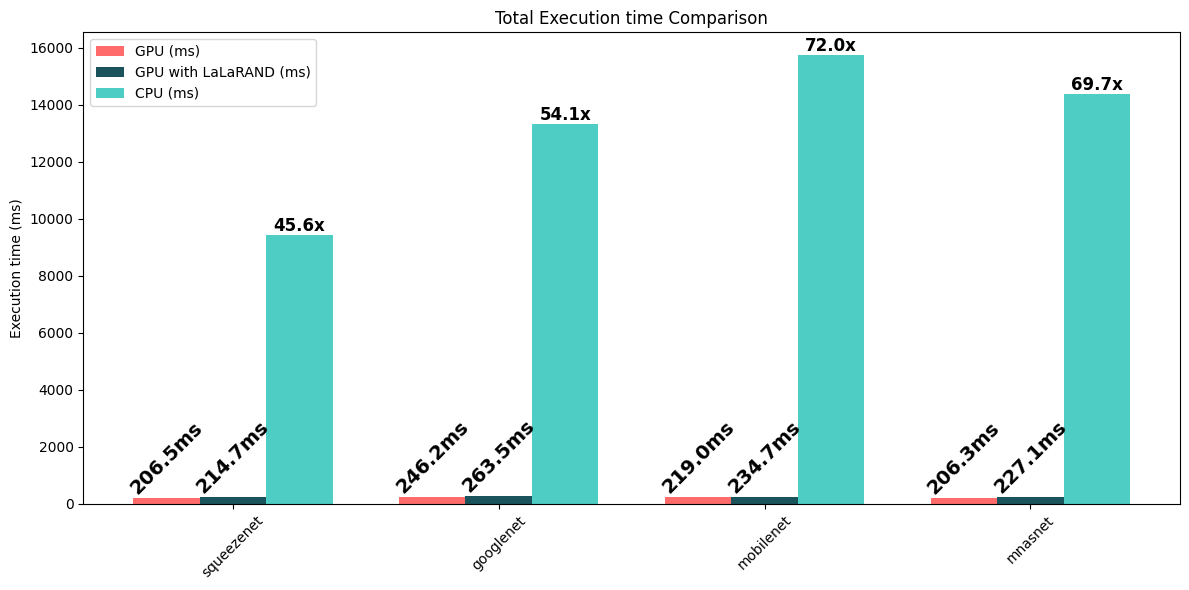

In [19]:
# ---------- Plot ----------
model_names = list(simple_results.keys())
gpu_times   = [simple_results[k]['gpu']*1000 for k in model_names]
lala_gpu_times = [simple_results[k]['lala_gpu']*1000 for k in model_names]
cpu_times   = [simple_results[k]['cpu']*1000 for k in model_names]

x = np.arange(len(model_names))
w = 0.25  # 막대 폭을 줄여서 3개 막대가 잘 보이도록

plt.figure(figsize=(12,6))
bars1 = plt.bar(x - w, gpu_times, width=w, label='GPU (ms)', color='#ff6b6b')
bars2 = plt.bar(x, lala_gpu_times, width=w, label='GPU with LaLaRAND (ms)', color='#1a535c')
bars3 = plt.bar(x + w, cpu_times, width=w, label='CPU (ms)', color='#4ecdc4')

# GPU 실행 시간 라벨 달기
for i, (bar, gpu_time) in enumerate(zip(bars1, gpu_times)):
    height = bar.get_height()
    plt.text(x[i] - w, height*1.02, f"{gpu_time:.1f}ms",
             ha='center', va='bottom', fontsize=14, fontweight='bold', rotation=45)

# GPU with LaLaRAND 실행 시간 라벨 달기
for i, (bar, lala_gpu_time) in enumerate(zip(bars2, lala_gpu_times)):
    height = bar.get_height()
    plt.text(x[i], height*1.02, f"{lala_gpu_time:.1f}ms",
             ha='center', va='bottom', fontsize=14, fontweight='bold', rotation = 45)

# CPU 실행 시간 라벨 달기
for i, (bar, cpu_time) in enumerate(zip(bars3, cpu_times)):
    cpu_vs_gpu_slowdown = cpu_times[i] / gpu_times[i]
    height = bar.get_height()
    plt.text(x[i] + w, height*1., f"{cpu_vs_gpu_slowdown:.1f}x",
             ha='center', va='bottom', fontsize=12, fontweight='bold',)

    
plt.xticks(x, model_names, rotation=45)
plt.ylabel('Execution time (ms)')
plt.title('Total Execution time Comparison')
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
results = {}
dummy_input = torch.randn(1000, 3, 224, 224).cuda()
for name, model in models.items():
    print(f"\n🔍 Processing {name}...")
    
    
    num_layers = len(get_all_layers(model))
    
    # GPU 실행
    gpu_config = [1] * num_layers
    gpu_model = LaLaRAND(copy.deepcopy(model), gpu_config)
    _ = gpu_model.forward(dummy_input)
    
    # CPU 실행
    cpu_config = [0] * num_layers
    cpu_model = LaLaRAND(copy.deepcopy(model), cpu_config)
    _ = cpu_model.forward(dummy_input)
    
    # 실행 시간만 추출
    # execution_times 전체를 저장 (딕셔너리로)
    results[name] = {
        'gpu': gpu_model.execution_times,
        'cpu': cpu_model.execution_times
    }
    print(f"✅ {name} completed!")


🔍 Processing squeezenet...
✅ squeezenet completed!

🔍 Processing googlenet...
✅ googlenet completed!

🔍 Processing mobilenet...
✅ mobilenet completed!

🔍 Processing mnasnet...
✅ mnasnet completed!


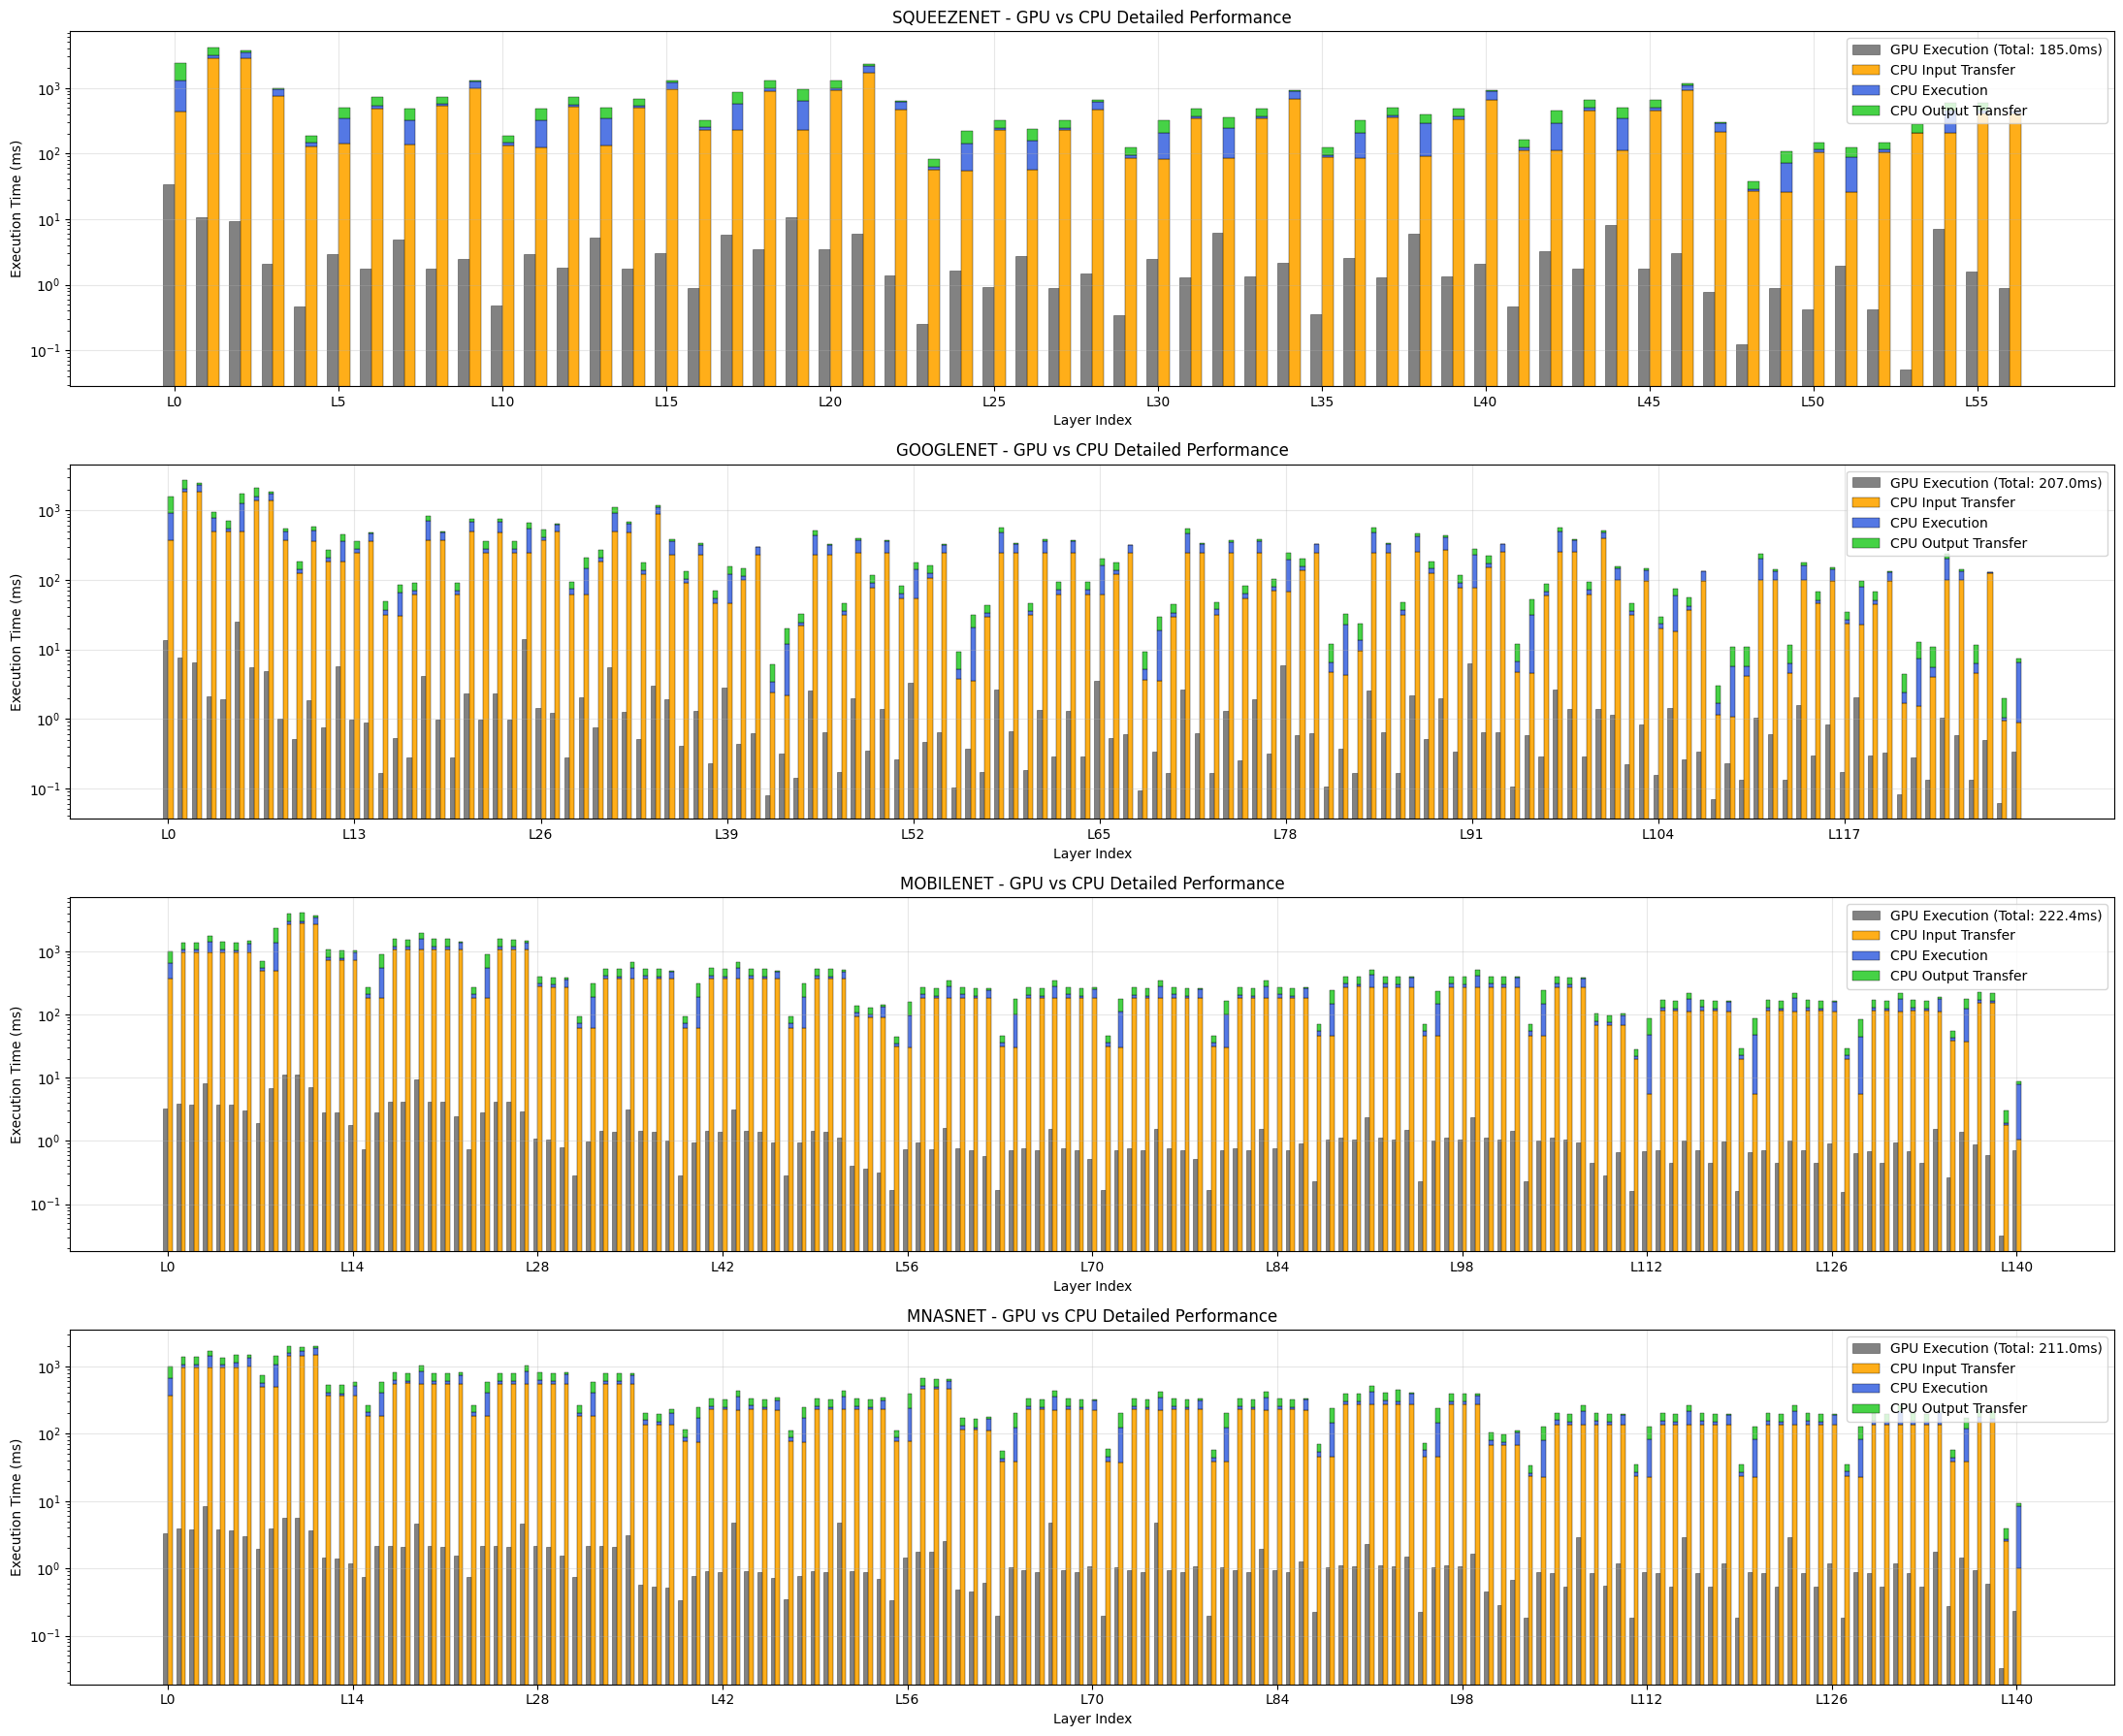


💾 Results saved to: /workspace/pytorch_bootcamp/results/stacked_comparison_20250723_081513.png
✅ Stacked analysis completed!


In [11]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

fig, axes = plt.subplots(4, 1, figsize=(22, 18))

for idx, (model_name, data) in enumerate(results.items()):
    ax = axes[idx] if len(results) > 1 else axes[0]
    
    # 실행 시간 추출
    gpu_exec_times = []
    cpu_input_times = []
    cpu_exec_times = []
    cpu_output_times = []
    layer_names = []
    
    # 데이터 추출 - 순서대로 정렬
    layer_data = {}
    
    # GPU 실행 시간 추출
    for key, value in data['gpu'].items():
        if 'execution_time' in key:
            layer_idx = int(key.split('_')[1])
            layer_data[layer_idx] = layer_data.get(layer_idx, {})
            layer_data[layer_idx]['gpu_exec'] = value['time_ms']
    
    # CPU 시간 추출 (input, execution, output)
    for key, value in data['cpu'].items():
        layer_idx = int(key.split('_')[1])
        layer_data[layer_idx] = layer_data.get(layer_idx, {})
        
        if 'input_memory_transfer' in key:
            layer_data[layer_idx]['cpu_input'] = value['time_ms']
        elif 'execution_time' in key:
            layer_data[layer_idx]['cpu_exec'] = value['time_ms']
        elif 'output_memory_transfer' in key:
            layer_data[layer_idx]['cpu_output'] = value['time_ms']
    
    # 순서대로 정렬하여 리스트 생성
    for layer_idx in sorted(layer_data.keys()):
        data_point = layer_data[layer_idx]
        gpu_exec_times.append(data_point.get('gpu_exec', 0))
        cpu_input_times.append(data_point.get('cpu_input', 0))
        cpu_exec_times.append(data_point.get('cpu_exec', 0))
        cpu_output_times.append(data_point.get('cpu_output', 0))
        layer_names.append(f"L{layer_idx}")
    
    # 총 실행 시간 계산
    gpu_total_time = sum(gpu_exec_times)
    
    # 막대 그래프
    x = np.arange(len(layer_names))
    width = 0.35
    
    # GPU는 단일 막대 
    bars1 = ax.bar(x - width/2, gpu_exec_times, width, label=f'GPU Execution (Total: {gpu_total_time:.1f}ms)', 
                    color="#070707", alpha=0.5, edgecolor='black', linewidth=0.5)

    # CPU 스택 막대 
    bars2 = ax.bar(x + width/2, cpu_input_times, width, label='CPU Input Transfer', 
                    color='#FFA500', alpha=0.9, edgecolor='black', linewidth=0.3) 
    bars3 = ax.bar(x + width/2, cpu_exec_times, width, bottom=cpu_input_times, 
                    label='CPU Execution', color='#4169E1', alpha=0.9, edgecolor='black', linewidth=0.3)  
    bars4 = ax.bar(x + width/2, cpu_output_times, width, 
                    bottom=np.array(cpu_input_times) + np.array(cpu_exec_times), label='CPU Output Transfer', color='#32CD32', alpha=0.9, edgecolor='black', linewidth=0.3)

    # 그래프 설정
    ax.set_xlabel('Layer Index')
    ax.set_ylabel('Execution Time (ms)')
    ax.set_title(f'{model_name.upper()} - GPU vs CPU Detailed Performance')
    ax.set_xticks(x[::max(1, len(x)//10)])  # x축 라벨 간소화
    ax.set_xticklabels([layer_names[i] for i in range(0, len(layer_names), max(1, len(x)//10))])
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')  # 로그 스케일
    
plt.tight_layout()

# 저장 및 표시
save_path = f'/workspace/pytorch_bootcamp/results/stacked_comparison_{timestamp}.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print("=" * 80)
print(f"\n💾 Results saved to: {save_path}")
print("✅ Stacked analysis completed!")



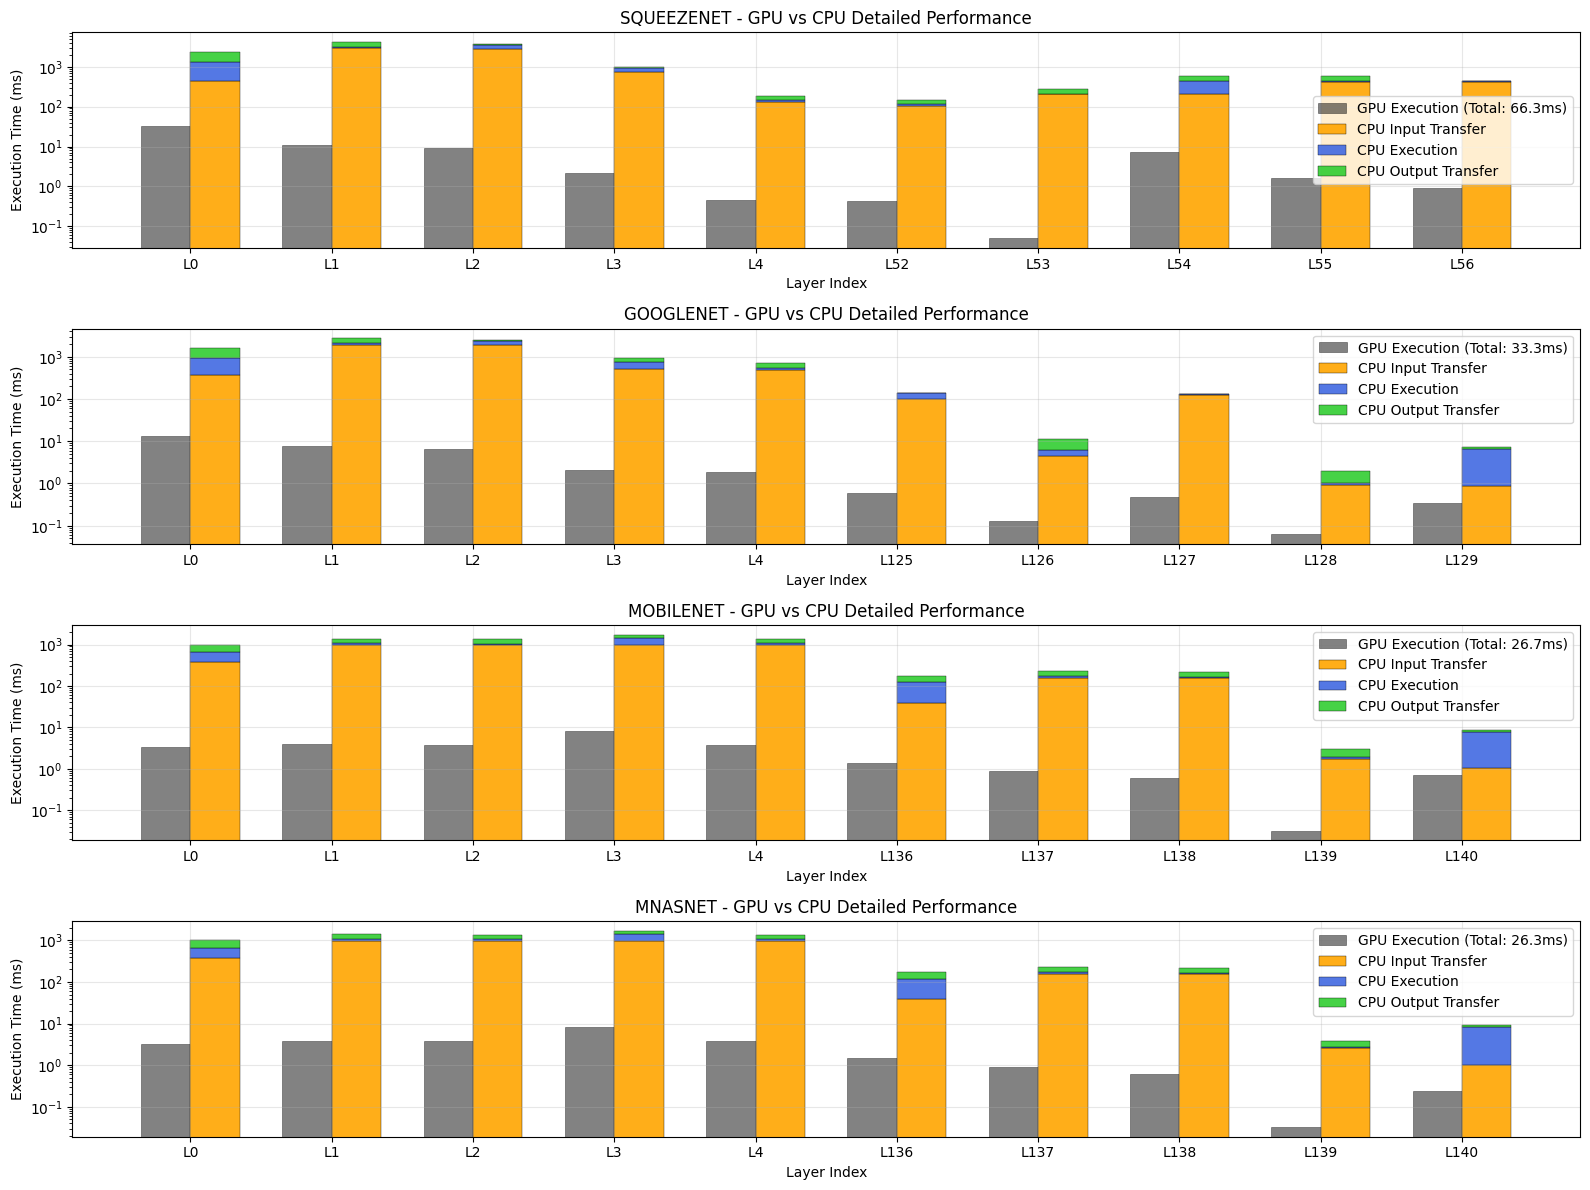


💾 Results saved to: /workspace/pytorch_bootcamp/results/stacked_comparison_20_20250723_081446.png
✅ Stacked analysis completed!


In [10]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

fig, axes = plt.subplots(4, 1, figsize=(16, 12))

for idx, (model_name, data) in enumerate(results.items()):
    ax = axes[idx] if len(results) > 1 else axes[0]
    
    # 실행 시간 추출
    gpu_exec_times = []
    cpu_input_times = []
    cpu_exec_times = []
    cpu_output_times = []
    layer_names = []
    
    # 데이터 추출 - 순서대로 정렬
    layer_data = {}
    
    # GPU 실행 시간 추출
    for key, value in data['gpu'].items():
        if 'execution_time' in key:
            layer_idx = int(key.split('_')[1])
            layer_data[layer_idx] = layer_data.get(layer_idx, {})
            layer_data[layer_idx]['gpu_exec'] = value['time_ms']
    
    # CPU 시간 추출 (input, execution, output)
    for key, value in data['cpu'].items():
        layer_idx = int(key.split('_')[1])
        layer_data[layer_idx] = layer_data.get(layer_idx, {})
        
        if 'input_memory_transfer' in key:
            layer_data[layer_idx]['cpu_input'] = value['time_ms']
        elif 'execution_time' in key:
            layer_data[layer_idx]['cpu_exec'] = value['time_ms']
        elif 'output_memory_transfer' in key:
            layer_data[layer_idx]['cpu_output'] = value['time_ms']
    
    # 순서대로 정렬하여 리스트 생성 (처음 5개 + 마지막 5개만)
    sorted_indices = sorted(layer_data.keys())

    # 처음 5개 + 마지막 5개 인덱스 추출
    selected_indices = sorted_indices[:5] + sorted_indices[-5:] if len(sorted_indices) > 10 else sorted_indices

    # 해당 인덱스에 대해만 그래프 데이터 저장
    for layer_idx in selected_indices:
        data_point = layer_data[layer_idx]
        gpu_exec_times.append(data_point.get('gpu_exec', 0))
        cpu_input_times.append(data_point.get('cpu_input', 0))
        cpu_exec_times.append(data_point.get('cpu_exec', 0))
        cpu_output_times.append(data_point.get('cpu_output', 0))
        layer_names.append(f"L{layer_idx}")
    
    # 총 실행 시간 계산
    gpu_total_time = sum(gpu_exec_times)
    
    # 막대 그래프
    x = np.arange(len(layer_names))
    width = 0.35
    
    # GPU는 단일 막대 
    bars1 = ax.bar(x - width/2, gpu_exec_times, width, label=f'GPU Execution (Total: {gpu_total_time:.1f}ms)', 
                    color="#070707", alpha=0.5, edgecolor='black', linewidth=0.5)

    # CPU 스택 막대 
    bars2 = ax.bar(x + width/2, cpu_input_times, width, label='CPU Input Transfer', 
                    color='#FFA500', alpha=0.9, edgecolor='black', linewidth=0.3) 
    bars3 = ax.bar(x + width/2, cpu_exec_times, width, bottom=cpu_input_times, 
                    label='CPU Execution', color='#4169E1', alpha=0.9, edgecolor='black', linewidth=0.3)  
    bars4 = ax.bar(x + width/2, cpu_output_times, width, 
                    bottom=np.array(cpu_input_times) + np.array(cpu_exec_times), label='CPU Output Transfer', color='#32CD32', alpha=0.9, edgecolor='black', linewidth=0.3)

    # 그래프 설정
    ax.set_xlabel('Layer Index')
    ax.set_ylabel('Execution Time (ms)')
    ax.set_title(f'{model_name.upper()} - GPU vs CPU Detailed Performance')
    ax.set_xticks(x[::max(1, len(x)//10)])  # x축 라벨 간소화
    ax.set_xticklabels([layer_names[i] for i in range(0, len(layer_names), max(1, len(x)//10))])
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')  # 로그 스케일
    
plt.tight_layout()

# 저장 및 표시
save_path = f'/workspace/pytorch_bootcamp/results/stacked_comparison_20_{timestamp}.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print("=" * 80)
print(f"\n💾 Results saved to: {save_path}")
print("✅ Stacked analysis completed!")



In [10]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  64
  On-line CPU(s) list:   0-63
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) Gold 6226R CPU @ 2.90GHz
    CPU family:          6
    Model:               85
    Thread(s) per core:  2
    Core(s) per socket:  16
    Socket(s):           2
    Stepping:            7
    CPU max MHz:         3900.0000
    CPU min MHz:         1200.0000
    BogoMIPS:            5800.00
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss 
                         ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art
                          arch_perfmon pebs bts rep_good nopl xtopology nonstop_
                         tsc cpuid aperfmperf pni pclmulqdq dtes64 monitor d